In [1]:
#from climaf.api import *
import xarray as xr
import pandas as pd

In [2]:
!ls /bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/*/*u10*

/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197901.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197902.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197903.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197904.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197905.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197906.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197907.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197908.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197909.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197910.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197911.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u100.197912.as1e5.GLOBAL_025.nc
/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_SF/1979/u10.197901.as1e5.G

In [3]:
!ls /bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp*

/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201901.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201902.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201903.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201904.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201905.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201906.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201907.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201908.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201909.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201910.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201911.fs1e5l.GLOBAL_01.nc
/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201912.fs1e5l.GLOBAL_01.nc


In [4]:
# https://github.com/rougier/windmap/blob/master/windmap.py

import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from matplotlib.collections import LineCollection

class Streamlines(object):
    """
    Copyright (c) 2011 Raymond Speth.
    Permission is hereby granted, free of charge, to any person obtaining a
    copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, sublicense,
    and/or sell copies of the Software, and to permit persons to whom the
    Software is furnished to do so, subject to the following conditions:
    The above copyright notice and this permission notice shall be included in
    all copies or substantial portions of the Software.
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
    FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
    DEALINGS IN THE SOFTWARE.
    See: http://web.mit.edu/speth/Public/streamlines.py
    """

    def __init__(self, X, Y, U, V, res=0.125,
                 spacing=2, maxLen=2500, detectLoops=False):
        """
        Compute a set of streamlines covering the given velocity field.
        X and Y - 1D or 2D (e.g. generated by np.meshgrid) arrays of the
                  grid points. The mesh spacing is assumed to be uniform
                  in each dimension.
        U and V - 2D arrays of the velocity field.
        res - Sets the distance between successive points in each
              streamline (same units as X and Y)
        spacing - Sets the minimum density of streamlines, in grid points.
        maxLen - The maximum length of an individual streamline segment.
        detectLoops - Determines whether an attempt is made to stop extending
                      a given streamline before reaching maxLen points if
                      it forms a closed loop or reaches a velocity node.
        Plots are generated with the 'plot' or 'plotArrows' methods.
        """

        self.spacing = spacing
        self.detectLoops = detectLoops
        self.maxLen = maxLen
        self.res = res

        xa = np.asanyarray(X)
        ya = np.asanyarray(Y)
        self.x = xa if xa.ndim == 1 else xa[0]
        self.y = ya if ya.ndim == 1 else ya[:,0]
        self.u = U
        self.v = V
        self.dx = (self.x[-1]-self.x[0])/(self.x.size-1) # assume a regular grid
        self.dy = (self.y[-1]-self.y[0])/(self.y.size-1) # assume a regular grid
        self.dr = self.res * np.sqrt(self.dx * self.dy)

        # marker for which regions have contours
        self.used = np.zeros(self.u.shape, dtype=bool)
        self.used[0] = True
        self.used[-1] = True
        self.used[:,0] = True
        self.used[:,-1] = True

        # Don't try to compute streamlines in regions where there is no velocity data
        for i in range(self.x.size):
            for j in range(self.y.size):
                if self.u[j,i] == 0.0 and self.v[j,i] == 0.0:
                    self.used[j,i] = True

        # Make the streamlines
        self.streamlines = []
        while not self.used.all():
            nz = np.transpose(np.logical_not(self.used).nonzero())
            # Make a streamline starting at the first unrepresented grid point
            self.streamlines.append(self._makeStreamline(self.x[nz[0][1]],
                                                         self.y[nz[0][0]]))


    def _interp(self, x, y):
        """ Compute the velocity at point (x,y) """
        i = (x-self.x[0])/self.dx
        ai = i % 1

        j = (y-self.y[0])/self.dy
        aj = j % 1

        i, j = int(i), int(j)
        
        # Bilinear interpolation
        u = (self.u[j,i]*(1-ai)*(1-aj) +
             self.u[j,i+1]*ai*(1-aj) +
             self.u[j+1,i]*(1-ai)*aj +
             self.u[j+1,i+1]*ai*aj)

        v = (self.v[j,i]*(1-ai)*(1-aj) +
             self.v[j,i+1]*ai*(1-aj) +
             self.v[j+1,i]*(1-ai)*aj +
             self.v[j+1,i+1]*ai*aj)

        self.used[j:j+self.spacing,i:i+self.spacing] = True

        return u,v

    def _makeStreamline(self, x0, y0):
        """
        Compute a streamline extending in both directions from the given point.
        """

        sx, sy = self._makeHalfStreamline(x0, y0, 1) # forwards
        rx, ry = self._makeHalfStreamline(x0, y0, -1) # backwards

        rx.reverse()
        ry.reverse()

        return rx+[x0]+sx, ry+[y0]+sy

    def _makeHalfStreamline(self, x0, y0, sign):
        """
        Compute a streamline extending in one direction from the given point.
        """

        xmin = self.x[0]
        xmax = self.x[-1]
        ymin = self.y[0]
        ymax = self.y[-1]

        sx = []
        sy = []

        x = x0
        y = y0
        i = 0
        while xmin < x < xmax and ymin < y < ymax:
            u, v = self._interp(x, y)
            theta = np.arctan2(v,u)

            x += sign * self.dr * np.cos(theta)
            y += sign * self.dr * np.sin(theta)
            sx.append(x)
            sy.append(y)

            i += 1

            if self.detectLoops and i % 10 == 0 and self._detectLoop(sx, sy):
                break

            if i > self.maxLen / 2:
                break

        return sx, sy

    def _detectLoop(self, xVals, yVals):
        """ Detect closed loops and nodes in a streamline. """
        x = xVals[-1]
        y = yVals[-1]
        D = np.array([np.hypot(x-xj, y-yj)
                      for xj,yj in zip(xVals[:-1],yVals[:-1])])
        return (D < 0.9 * self.dr).any()

  0%|          | 0/27 [00:00<?, ?it/s]MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
28it [00:57,  2.18s/it]                        

ValueError: unknown file extension: .mp4

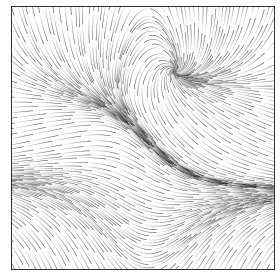

In [6]:
# Example from https://github.com/rougier/windmap/blob/master/windmap.py

Y, X = np.mgrid[-3:3:100j, -3:3:100j]
U, V = -1 - X**2 + Y, 1 + X - X*Y**2
speed = np.sqrt(U*U + V*V)

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1, aspect=1)


lengths = []
colors = []
lines = []

s = Streamlines(X, Y, U, V)
for streamline in s.streamlines:
    x, y = streamline
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(segments)
    
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n,1) + np.random.uniform(0,1)
    C = np.zeros((n,3))
    C[:] = (L*1.5) % 1

    #linewidths = np.zeros(n)
    #linewidths[:] = 1.5 - ((L.reshape(n)*1.5) % 1)

    # line = LineCollection(segments, color=colors, linewidth=linewidths)
    line = LineCollection(segments, color=C, linewidth=0.5)
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    
    ax.add_collection(line)

def update(frame_no):
    for i in range(len(lines)):
        lengths[i] += 0.05
        colors[i][:] = (lengths[i]*1.5) % 1
        lines[i].set_color(colors[i])
    pbar.update()

ax.set_xlim(-3,+3), ax.set_xticks([])
ax.set_ylim(-3,+3), ax.set_yticks([])
plt.tight_layout()

n = 27
# animation = FuncAnimation(fig, update, interval=10)
animation = FuncAnimation(fig, update, frames=n, interval=20)
pbar = tqdm.tqdm(total=n)
# animation.save('wind.mp4', writer='ffmpeg', fps=60)
animation.save('wind.gif', writer='imagemagick', fps=30)
pbar.close()
plt.show()

In [14]:
root = '/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/'
!ls /bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201904.fs1e5l.GLOBAL_01.nc

/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201904.fs1e5l.GLOBAL_01.nc


In [92]:
# Define zone
latlim=[5,0]#[50,0]
lonlim=[60,65]#[45,120]

In [93]:
year='2019'
month='01'

In [94]:
var1='u10'
var2='v10'

In [95]:
slice(latlim[0],latlim[1])

slice(5, 0, None)

In [96]:
file=root+str(year)+'/'+var1+'.'+str(year)+str(month)+'.fs1e5l.GLOBAL_01.nc'
U10=xr.open_dataset(file)[var1].sel(latitude=slice(latlim[0],latlim[1]), longitude=slice(lonlim[0],lonlim[1]))

In [97]:
file=root+str(year)+'/'+var2+'.'+str(year)+str(month)+'.fs1e5l.GLOBAL_01.nc'
V10=xr.open_dataset(file)[var2].sel(latitude=slice(latlim[0],latlim[1]), longitude=slice(lonlim[0],lonlim[1]))

In [98]:
U10.shape, V10.shape

((744, 51, 51), (744, 51, 51))

In [99]:
X, Y = np.meshgrid(U.longitude, U.latitude)

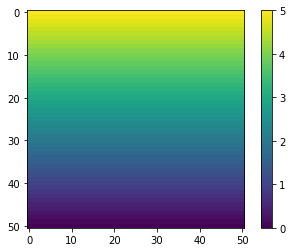

In [100]:
plt.imshow(Y); plt.colorbar()

In [101]:
U=U10[0,:,:]
V=V10[0,:,:]

In [102]:
U.shape, V.shape, X.shape, Y.shape

((51, 51), (51, 51), (51, 51), (51, 51))

In [103]:
speed = np.sqrt(U*U + V*V)


/proju/ipslfs/thredds/jservon/miniconda/envs/analyse_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in sqrt


KeyboardInterrupt: 

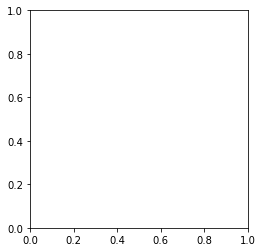

In [104]:
# Test with ERA5 data

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1, aspect=1)


lengths = []
colors = []
lines = []

s = Streamlines(X, Y, U, V)
for streamline in s.streamlines:
    x, y = streamline
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(segments)
    
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n,1) + np.random.uniform(0,1)
    C = np.zeros((n,3))
    C[:] = (L*1.5) % 1

    #linewidths = np.zeros(n)
    #linewidths[:] = 1.5 - ((L.reshape(n)*1.5) % 1)

    # line = LineCollection(segments, color=colors, linewidth=linewidths)
    line = LineCollection(segments, color=C, linewidth=0.5)
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    
    ax.add_collection(line)

def update(frame_no):
    for i in range(len(lines)):
        lengths[i] += 0.05
        colors[i][:] = (lengths[i]*1.5) % 1
        lines[i].set_color(colors[i])
    pbar.update()

ax.set_xlim(-3,+3), ax.set_xticks([])
ax.set_ylim(-3,+3), ax.set_yticks([])
#ax.set_xlim(-3,+3), ax.set_xticks([])
#ax.set_ylim(-3,+3), ax.set_yticks([])
plt.tight_layout()

n = 3#27
# animation = FuncAnimation(fig, update, interval=10)
animation = FuncAnimation(fig, update, frames=n, interval=20)
pbar = tqdm.tqdm(total=n)
# animation.save('wind.mp4', writer='ffmpeg', fps=60)
animation.save('wind.gif', writer='imagemagick', fps=30)
pbar.close()
plt.show()

In [ ]:
# Superposing precipitation
!ls /bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/2019/tp.201905.fs1e5l.GLOBAL_01.nc
root_p='/bdd/ERA5-Land/NETCDF/GLOBAL_01/hourly/FC_SF/'
var3='tp'
file=root_p+str(year)+'/'+var3+'.'+str(year)+str(month)+'.fs1e5l.GLOBAL_01.nc'
precip=xr.open_dataset(file)[var3].sel(latitude=slice(latlim[0],latlim[1]), longitude=slice(lonlim[0],lonlim[1]))